# Data Scientist Technical Test
By Gary Sztajnman
on Dec. 24, 2016

This notebook presents the analysis of data extracted from the us census bureau database.
The goal is to “modelize” / “predict” the relation between all features and the income level for a person represented by a record.


Summary:
  - Requirement
  - Load data
  - Visualization
  - Data cleaning and feature engineering
  - Prediction
  - Evaluation
  - Conclusion

# Requirement

Language: Python 2.7

Libraries:
 - Numpy
 - Pandas
 - Matplotlib
 - Seaborn
 - sklearn
 - incf.countryutils:
    - To convert countries to continent
    - Link: https://pypi.python.org/pypi/incf.countryutils
 - requests
 - zipfile
 - StringIO

In [1]:
import numpy as np
import pandas as pd

#To download data
import requests, zipfile, StringIO

# Load data

In [131]:
class censusdata(object):
    '''
    Object to load and store the data in different form
    '''
    def __init__(self):
        self.url = 'http://thomasdata.s3.amazonaws.com/ds/us_census_full.zip'
        
        #download data
        self.download_data()
        
        self.metadata = 'us_census_full/census_income_metadata.txt'
        self.train = 'us_census_full/census_income_learn.csv'
        self.test = 'us_census_full/census_income_test.csv'
        self.columns = self.get_column()               # Features
        self.df_train = self.load_data(self.train)     # Train data
        self.df_test = self.load_data(self.test)       # Test data
        
        #Handling missing values 
        self.NA = [' ?', ' NA', ' Not in universe'] # Values considered missing
        self.cut_off = 40 # If there are more than 40% missing drop the feature
        self.too_many_na = [] # features with too many missing values
        
        #Storing cleaned data
        self.X = None
        self.Y = None
        self.X_test = None
        self.Y_test = None
        self.features = None #Final features selected by the model
        
    def download_data(self):
        if not os.path.exists('us_census_full'):
            r = requests.get(self.url, stream=True)
            z = zipfile.ZipFile(StringIO.StringIO(r.content))
            z.extractall()  
            print 'Data downloaded'
        else:
            print 'Data already exists'
    
    def get_info(self):
        '''
        Get correspondance between feature name and feature code
        '''
        col_info = []
        with open(self.metadata) as metadata:
            for i, line in enumerate(metadata):
                if 22<i<68:
                    line = line.split('\t')
                    col_info.append([line[-1][:-1],line[0][2:]])

        return pd.DataFrame(col_info, columns = ['code','details'])
    
    def get_column(self):
        '''
        Read metadata and return columns
        '''
        df_columns = []
        with open(self.metadata) as metadata:
            for i, line in enumerate(metadata):
                if 141<i:
                    col = line.split(':')[0]
                    if '|' in col:
                        continue
                    df_columns.append(col)
                    
        return df_columns + ['income']
        
    def load_data(self, file_loc):
        df = pd.read_csv(file_loc)
        df.columns = self.columns
        return df
        
    def read_meta(self):
        with open(self.metadata) as metadata:
            for line in metadata:
                print(line)
    
    def description(self, data):
        '''
        Compute statistic of univariate numerical features
        '''
        X_data = data.drop('income', axis = 1)
        return X_data.describe().T.drop(['count','25%','75%'],axis =1).T.round(2)
    
    def missing(self,cut_off):
        '''
        Detect features with missing values above a threshold.
        '''
        df = self.df_train
        for col in df.columns:
            if df[col].dtype in ['int64','float64']:
                missing_values = (df[col].isnull().sum() / df.shape[0]) * 100
            else:
                missing_values = ((df[col].isnull().sum() + sum(df[col].isin(cd.NA))) / float(df.shape[0])) * 100
            if missing_values>cut_off:
                cd.too_many_na.append(col)

In [132]:
cd = censusdata()
cd.df_train.head(2)

Data already exists


,age,class of worker,detailed industry recode,detailed occupation recode,education,wage per hour,enroll in edu inst last wk,marital stat,major industry code,major occupation code,...,country of birth father,country of birth mother,country of birth self,citizenship,own business or self employed,fill inc questionnaire for veteran's admin,veterans benefits,weeks worked in year,year,income
0,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.
1,18,Not in universe,0,0,10th grade,0,High school,Never married,Not in universe or children,Not in universe,...,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95,- 50000.


# Visualization 

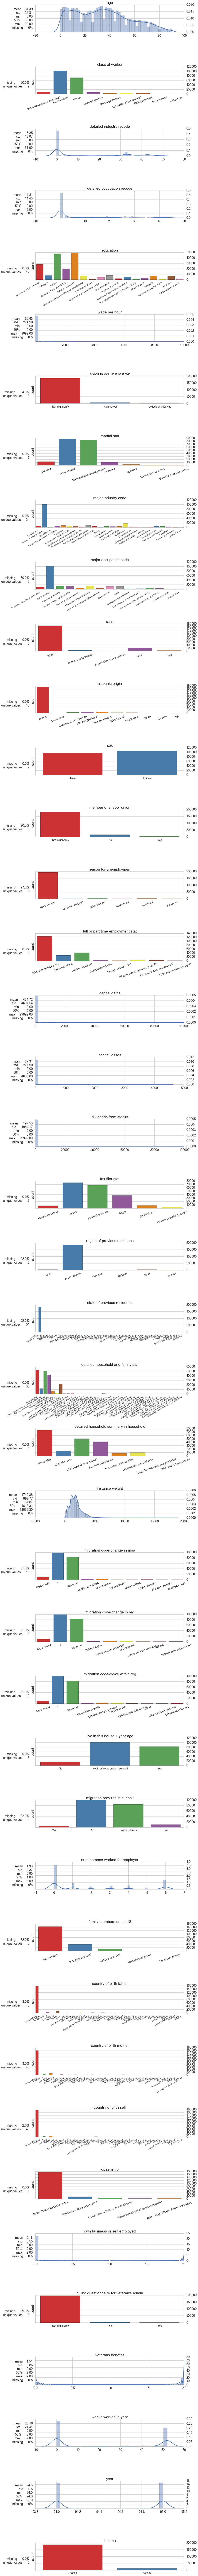

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns
# Draw inline
%matplotlib inline
# Set figure aesthetics
sns.set_style("whitegrid")
sns.set_context("poster", font_scale=1.1)


df = cd.df_train
X_num_desc = cd.description(cd.df_train)
fig, axes  = plt.subplots(nrows=df.shape[1], ncols=1, figsize=(15, 200))
pad = 5


for ax,col in zip(axes,df.columns):
    '''
    Plotting a barplot for categorical data
    And a distribution plot for numerical data
    '''
    if df[col].dtype in ['int64','float64']:
        sns.distplot(df[col],ax=ax)
        
        # Adding information about the feature
        missing_values = (df[col].isnull().sum() / df.shape[0]) * 100
        text = '\n'.join(str(X_num_desc[col]).split('\n')[:-1] + ['missing      '+str(missing_values)+'%'])
    
    else:
        sns.countplot(x=col, data=df, palette="Set1",ax=ax)
        
        
        # Adding information about the feature
        unique = df[col].unique()
        missing_values = ((df[col].isnull().sum() + sum(df[col].isin(cd.NA))) / float(df.shape[0])) * 100
        text = 'missing      '+str(round(missing_values))+'%\nunique values      '+str(len(unique))
        
        # Change design of xlabels 
        for tick in ax.get_xticklabels():
            tick.set_fontsize(14)
        if 5<=len(unique)<=10:
            ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=20, ha='center')
        elif len(unique)>10:
            ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=30, ha='right')
            for tick in ax.get_xticklabels():
                tick.set_fontsize(12)

    #Adding information 
    ax.set_title(col)
    ax.yaxis.tick_right()
    ax.xaxis.label.set_visible(False)
    ax.annotate(text, xy=(0, 0), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label,size='small', 
                ha='right', va='center', textcoords='offset points'
                )
    

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.show()

# Data cleaning and feature engineering

### Reducing number of categories previous to binary encoding of categorical data

In [88]:
def categorical_reduction(X_data, cut_off=40):
    
    # Deleting columns with too many missing values:
    cd.missing(cut_off)
    X = X_data.drop(cd.too_many_na, axis = 1)
    categorical = X.columns.difference(X._get_numeric_data().columns)
    for col in categorical:
        X.loc[X[col].isin(cd.NA), col] =  X[col].value_counts().index[0]
    X_num = X._get_numeric_data().copy()
    X_cat = X[categorical].copy()


    # Reducing nuber of houshold type
    household = 'detailed household and family stat'
    X_cat.loc[X_cat[household].str.startswith(' Child 18+'), household] =  ' Child 18+'
    X_cat.loc[X_cat[household].str.startswith(' Child <18'), household] =  ' Child <18'
    other = X_cat[household].value_counts()[X_cat[household].value_counts() <10000].index
    other = other.difference([' Child 18+', ' Child <18'])
    X_cat.loc[X_cat[household].isin(other), household] = ' All Other'

    # From countries to continent
    from incf.countryutils import transformations
    def country_to_cn(country):
        if country == ' United-States':
            return 'United-States'
        else:
            try: 
                return transformations.cn_to_ctn(country[1:])
            except KeyError:
                return 'Other'
    X_cat['country of birth father'] = X['country of birth father'].apply(country_to_cn)
    X_cat['country of birth mother'] = X['country of birth mother'].apply(country_to_cn)
    X_cat['country of birth self'] = X['country of birth self'].apply(country_to_cn)

    # Reduce the number of education type
    X_cat.loc[X['education'].str.contains('grade'), 'education'] = ' Below High School diploma'
    X_cat.loc[X['education'].str.contains('Associates'), 'education'] = ' Associates degree'
    
    return X_cat, X_num

I decided to keep all the categories of "major industry code" because they all seem very different and strongly connected with income

### Feature engineering

Create polynomial features using continuous variable linked to financial profit

In [81]:
from sklearn.preprocessing import PolynomialFeatures
def feature_engineering(X_num):
    finance = ['capital gains', 'capital losses', 'dividends from stocks']
    X_finance = X_num[finance].copy()

    poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
    X_finance_2 = poly.fit_transform(X_finance)
    X_finance_2.shape

    poly_col = []
    for col in poly.powers_:
        name = finance[0]+ '^' +str(col[0]) + ' * ' + finance[1]+ '^' +str(col[1]) + ' * ' + finance[2] + '^' + str(col[2])
        poly_col.append(name)

    return pd.DataFrame(X_finance_2, columns = poly_col)

### Feature normalization and binary encoding

In [82]:
from sklearn import preprocessing
def normalization(X_cat, X_num, df_finance_2, y):
    
    # Build dummy variables with categorical data
    X_cat_dum = pd.get_dummies(X_cat)

    # Normalize numerical data
    min_max_scaler = preprocessing.MinMaxScaler()
    X_num_scaled = pd.DataFrame(min_max_scaler.fit_transform(X_num), columns = X_num.columns)

    # Merge numerical, categorical and feature engineered
    X_clean = pd.concat([X_num_scaled, df_finance_2, X_cat_dum], axis=1)

    #Encode Y
    Y = y == ' 50000+.'
    
    return X_clean, Y

### Feature Selection

In [12]:
from sklearn.feature_selection import SelectKBest, chi2
def selection(X,Y):
    # Apply Variance threshold
    X = X.loc[:,X.std(axis=0)>0.1] 

    # I decided to drop around 30% of the features to avoid overfitting, 
    # potentially increase the performance of the model
    # and to reduce the running time of the modelling.
    ch2 = SelectKBest(chi2, k=70)
    X_new = ch2.fit_transform(X, Y)
    selected_columns = X.columns[ch2.get_support()]
    
    return pd.DataFrame(X_new, columns = selected_columns), selected_columns

### Get cleaned train data

In [14]:
X_cat, X_num = categorical_reduction(cd.df_train.drop('income', axis=1))
df_finance_2 = feature_engineering(X_num)
cd.X, cd.Y = normalization(X_cat, X_num, df_finance_2, cd.df_train.income)
cd.X, cd.features =  selection(cd.X, cd.Y)

print('X', cd.X.shape, 'Y', cd.Y.shape)

('X', (199522, 70), 'Y', (199522,))


# Prediction

In [52]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier

### Methodology
After filtering features based on their variance and chi2 score,
I tried 2 classifiers that proved to be very efficient in the past in order to predict the income: 

 - LogisticRegression because it is fast to run. I use L2 regularization.
 - RandomForest because it uses averaging of trees to improve the predictive accuracy and control over-fitting
 
I tried different parameters and determined the best one based on cross validation.

Because, we try to predict 2 classes that are very imbalanced, I used F1 score to evaluate the best model.
The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0

### LogisticRegression

In [55]:
lr_score = {}
for C in [1,5,10]:
    print 'LogisticRegression with C:', C
    lr = LogisticRegression(C=C, random_state=123)
    scores_lr = cross_val_score(lr, cd.X, cd.Y, scoring='f1')
    lr_score[scores_lr.mean()] = {'model': lr}
    print scores_lr.mean()

LogisticRegression with C: 1
0.212869558663
LogisticRegression with C: 5
0.310557452038
LogisticRegression with C: 10
0.290241571569


### Random Forest

In [93]:
random_score = {}
for max_depth in [10,50,None]:
    print 'RandomForestClassifier with max_depth:', max_depth
    rf = RandomForestClassifier(max_depth=max_depth, n_estimators=100, random_state=123)

    scores_rf = cross_val_score(rf, cd.X, cd.Y, scoring='f1')
    random_score[scores_rf.mean()] = {'model':rf}
    print scores_rf.mean()

RandomForestClassifier with max_depth: 10
0.386847208653
RandomForestClassifier with max_depth: 50
0.501768499318
RandomForestClassifier with max_depth: None
0.50013980945


Best model: Random Forest with max_depth: 50

# Evaluation

### Base model

A base model that randomly predicts y, would have a 11% F1_score.

A base model that uses the prior distribution of y, would perform better on accuracy but don't work with F1_score.

In [94]:
dclf = DummyClassifier(strategy='uniform', random_state=123)
model = dclf.fit(cd.X, cd.Y)
scores_dclf = f1_score(model.predict(cd.X), cd.Y)
scores_dclf
print('Base model f1_score is :{}%').format(round(scores_dclf*100,2))

Base model f1_score is :11.04%


In [95]:
dclf_p = DummyClassifier(strategy='prior', random_state=123)
model_p = dclf_p.fit(cd.X, cd.Y)
scores_dclf_p = np.mean(model_p.predict(cd.X)==cd.Y)
scores_dclf_p
print('Base model accuracy is :{}%').format(round(scores_dclf_p*100,2))

Base model accuracy is :93.79%


### Get cleaned test data

In [89]:
X_test_cat, X_test_num = categorical_reduction(cd.df_test.drop('income', axis=1))
df_test_finance_2 = feature_engineering(X_test_num)
cd.X_test, cd.Y_test = normalization(X_test_cat, X_test_num, df_test_finance_2, cd.df_test.income)
cd.X_test = cd.X_test.loc[:,cd.features]
print('X', cd.X_test.shape, 'Y', cd.Y_test.shape) 

('X', (99761, 70), 'Y', (99761,))


### Test best model using accuracy score and F1_score

Our best model is Random Forest. Among the few parameters we tried, we will use the ones that optimized our cross validation f1 score.

In [92]:
best_model = random_score[max(random_score.keys())]['model']
best_model.fit(cd.X, cd.Y)
y_pred = best_model.predict(cd.X_test)
accuracy_result = np.mean(cd.Y_test==y_pred)
f1_result = f1_score(cd.Y_test,y_pred)


print('Test accuract result is :{}%').format(round(accuracy_result*100,2))
print('Test f1_score result is :{}%').format(round(f1_result*100,2))

Test accuract result is :95.13%
Test f1_score result is :51.53%


# Conclusion

Our best model is able to beat the base model on both the F1_score and the accuracy. It does approximately as good as the result presented in the metadata file.

### Feature importance and insights

Feature ranking:
1. age : (0.164440932367)
2. detailed industry recode : (0.0812763672276)
3. num persons worked for employer : (0.0639323809289)
4. own business or self employed : (0.0631972823371)
5. veterans benefits : (0.0614096406815)
6. weeks worked in year : (0.051725368301)
7. capital gains^1 * capital losses^0 * dividends from stocks^0 : (0.0484939538141)
8. capital gains^0 * capital losses^1 * dividends from stocks^0 : (0.0442973016176)
9. capital gains^0 * capital losses^0 * dividends from stocks^1 : (0.0209551943952)
10. capital gains^2 * capital losses^0 * dividends from stocks^0 : (0.0187972208086)


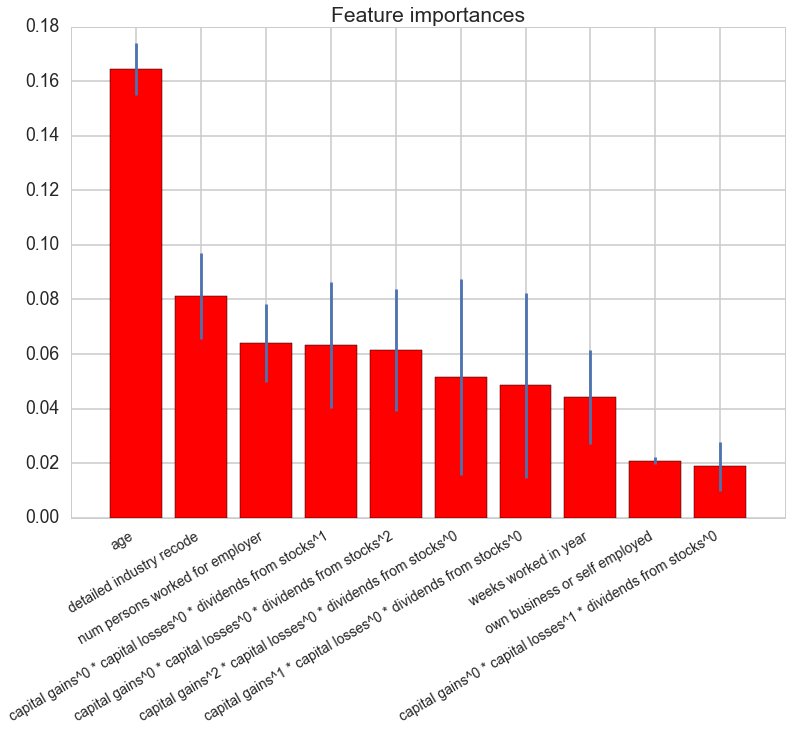

In [97]:
#  Visualizating the importance of the top 10 features
top = 10
importances = best_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in best_model.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1][:top]

# Print the feature ranking
print("Feature ranking:")
for i in range(top):
    print("{}. {} : ({})".format(i + 1, cd.X.columns[i], importances[indices[i]]))

    
# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(top), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(top), cd.X.columns[indices], 
           rotation=30, ha='right' , fontsize = 14)
plt.xlim([-1, top])
plt.show()

Insights:

 - Age is the strongest feature of our RandomForest model
 - The other strongest features are related to occupation, industry and financial gain.
 - The features generated using the polynomial feature engineering seemed to be very related to income. This is what we expected. It makes sense that the more dividend you receive, the higher your income is.


# Improvement

 - Visualization:
   - To obtain better visualization on geographical data, plotting on a map would be more appropriate
   - Improve the visualization of certain univariate for which the range is wide and the data is centered so that the actual plot squeezes the data in one bar.
   - Add visualizations of multiple variables and relation between features and Y to better understand which are the most important variables for the feature engineering part
  
 - Feature engineering
   - Because features related to financial gain are sparse, it does not seem necessary to compute the relation between the different financial variables.
   - Implement new features based on the findings of more visualization
  
 - Modeling
   - Try other models: Adaboost, SVM...
   - Implement GridSearch to test more parameters
   - Apply models to a balanced random subsamples of my large unbalanced dataset. That could be achieved using a random undersampling of the majority class and a random upsampling of the minority class. The goal is to prevent the classifier from always predicting the majority class.
   - I was also interested in using Theano to see how a deep learning Multi-Layer Perceptron would perform on this problem. But my computer is very slow when it comes to neural network.
   
 - Evaluation
   - Compute and plot the Area Under the Curve for a precision-recall curve which considers various thresholds result in different true positive/false positive rates.

### Thank you for reading